**Author Note**:

I wrote this notebook while learning DSPy. Use it to learn yourself and feel free to suggest improvements.

This notebook is the guided version. Feel free to explore other ways to reframe the problem, or switch to the solutions/non-guided versions on my github.

Estimated time: ~1h

Estimated API cost (using 4.1 nano) :

* < $0.1 without optimization runs

* < $1.0 with optimization runs

Author: Rayane Hachemi ([github](https://github.com/rayanehmi))

# DSPy Guilded Rose Kata

## Problem Introduction

The Guilded Rose kata is a refactoring exercise for developpers. Learn more about the problem on this GitHub repository: https://github.com/emilybache/GildedRose-Refactoring-Kata.



### Guilded Rose Item Update Code

The goal of the kata is to refactor the following code into a cleaner version, and add a new functionality :

```python
class GildedRose(object):

    def __init__(self, items):
        self.items = items

    def update_quality(self):
        for item in self.items:
            if item.name != "Aged Brie" and item.name != "Backstage passes to a TAFKAL80ETC concert":
                if item.quality > 0:
                    if item.name != "Sulfuras, Hand of Ragnaros":
                        item.quality = item.quality - 1
            else:
                if item.quality < 50:
                    item.quality = item.quality + 1
                    if item.name == "Backstage passes to a TAFKAL80ETC concert":
                        if item.sell_in < 11:
                            if item.quality < 50:
                                item.quality = item.quality + 1
                        if item.sell_in < 6:
                            if item.quality < 50:
                                item.quality = item.quality + 1
            if item.name != "Sulfuras, Hand of Ragnaros":
                item.sell_in = item.sell_in - 1
            if item.sell_in < 0:
                if item.name != "Aged Brie":
                    if item.name != "Backstage passes to a TAFKAL80ETC concert":
                        if item.quality > 0:
                            if item.name != "Sulfuras, Hand of Ragnaros":
                                item.quality = item.quality - 1
                    else:
                        item.quality = item.quality - item.quality
                else:
                    if item.quality < 50:
                        item.quality = item.quality + 1


class Item:
    def __init__(self, name, sell_in, quality):
        self.name = name
        self.sell_in = sell_in
        self.quality = quality

    def __repr__(self):
        return "%s, %s, %s" % (self.name, self.sell_in, self.quality)
```

Here is the set of rules in natural language:

---

### Gilded Rose Requirements Specification

Hi and welcome to team Gilded Rose. As you know, we are a small inn with a prime location in a prominent city ran by a friendly innkeeper named Allison. We also buy and sell only the finest goods. Unfortunately, our goods are constantly degrading in `Quality` as they approach their sell by date.

We have a system in place that updates our inventory for us. It was developed by a no-nonsense type named Leeroy, who has moved on to new adventures. Your task is to add the new feature to our system so that we can begin selling a new category of items. First an introduction to our system:

- All `items` have a `SellIn` value which denotes the number of days we have to sell the `items`
- All `items` have a `Quality` value which denotes how valuable the item is
- At the end of each day our system lowers both values for every item

Pretty simple, right? Well this is where it gets interesting:

- Once the sell by date has passed, `Quality` degrades twice as fast
- The `Quality` of an item is never negative
- __"Aged Brie"__ actually increases in `Quality` the older it gets
- The `Quality` of an item is never more than `50`
- __"Sulfuras"__, being a legendary item, never has to be sold or decreases in `Quality`
- __"Backstage passes"__, like aged brie, increases in `Quality` as its `SellIn` value approaches;
	- `Quality` increases by `2` when there are `10` days or less and by `3` when there are `5` days or less but
	- `Quality` drops to `0` after the concert

We have recently signed a supplier of conjured items. This requires an update to our system:

- __"Conjured"__ items degrade in `Quality` twice as fast as normal items

Feel free to make any changes to the `UpdateQuality` method and add any new code as long as everything still works correctly. However, do not alter the `Item` class or `Items` property as those belong to the goblin in the corner who will insta-rage and one-shot you as he doesn't believe in shared code ownership (you can make the `UpdateQuality` method and `Items` property static if you like, we'll cover for you).

Just for clarification, an item can never have its `Quality` increase above `50`, however __"Sulfuras"__ is a legendary item and as such its `Quality` is `80` and it never alters.

---

## What is DSPy ?

"DSPy is a declarative framework for building modular AI software. It allows you to **iterate fast on structured code**, rather than brittle strings, and offers algorithms that **compile AI programs into effective prompts and weights** for your language models, whether you're building simple classifiers, sophisticated RAG pipelines, or Agent loops.

Instead of wrangling prompts or training jobs, DSPy (Declarative Self-improving Python) enables you to **build AI software from natural-language modules** and to generically compose them with different models, inference strategies, or learning algorithms. This makes AI software more reliable, maintainable, and portable across models and strategies."

Read more: https://dspy.ai/.

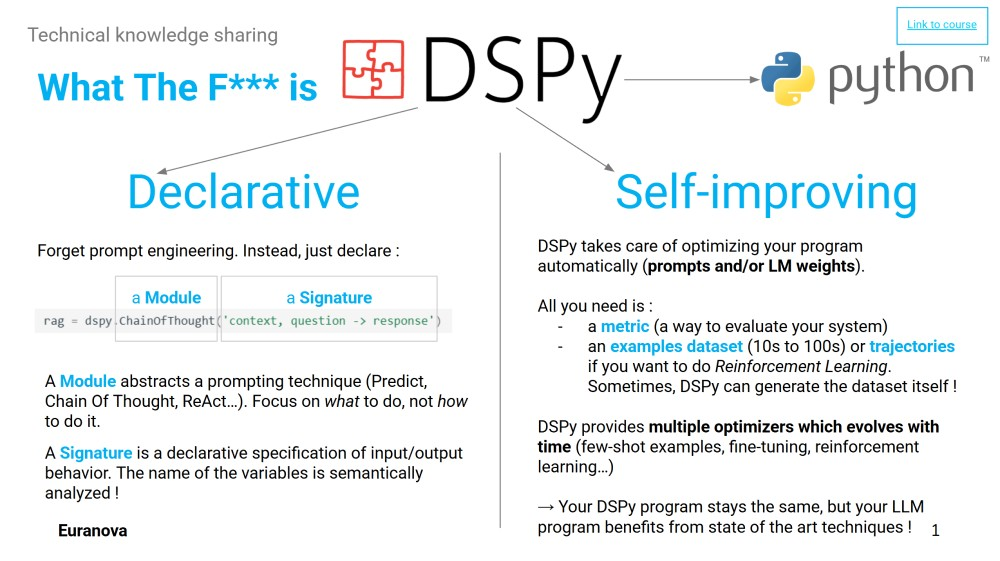

## What's the plan ?

We want to delegate the update function as a LM pass using DSPy.

You can choose to either update items one by one and loop over the list of items, or provide a whole list of items directly.

Similarly, you can decide where to give your LM module agency: for example, by providing it an 'update item tool'.

# Reframing the problem into a DSPy program

---
## Designing our system

Our system will have as an input a set of rules and a list of items to update. It will the return a list of updated items.

✍️ Design choices

* In this notebook in particular, we will include the rules not as an input but as a hardcoded component of our module, since we aren't interested in having multiple rules sets.

* We will do **one item per LM call** to minimize context length because the items are independent. Looping over a list of items is trivial and isn't what we are trying to learn here.

* We will use the ChainOfThought DSPy module as a prompt technique because it is suited for step by step rule application. Learn more about DSPy modules in the section "Defining a DSPy Module".

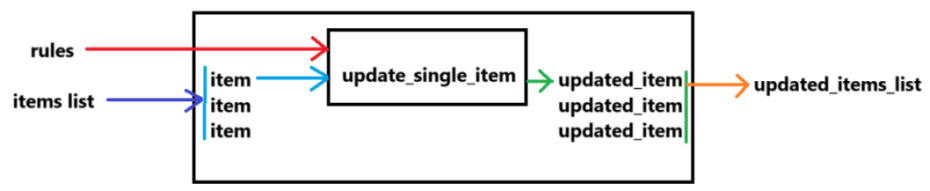

---

## API & DSPy Setup


Let's setup our LM and define some key variables for later.

We use API-available LLMs for simplicity's sake. If you are hosting your own LLM, refer to DSPy documentation to learn how to connect to it.

✍️ First, let's set our API key. This notebook chooses OpenAI as an example.

In [ ]:
api_key = '<YOUR-API-KEY-HERE>'

In [ ]:
# Alternatively, you can store your api keys directly in the Colab, in the Secrets section on the left.
# from google.colab import userdata
# api_key = userdata.get('OPENAI_API_KEY')

The following call lists available models and serves as an OpenAI API key test.

In [ ]:
import requests
response = requests.get(
  'https://api.openai.com/v1/models',
  headers={
    'Authorization': 'Bearer ' + api_key,
    'Content-Type': 'application/json'
  }
)
assert response.status_code == 200, response.text
print([model['id'] for model in response.json()['data']])

Install required libraries. Don't worry if pip complains about `torch` and `gcsfs` requirements.

In [ ]:
!pip install -qq dspy==2.6.26

Fix Pydantic version to avoid specific warnings:

In [ ]:
!pip install -qq pydantic==2.11.7

Set up LMs. We choose the GPT-4.1 family, which is known for having good instruction following (https://openai.com/index/gpt-4-1/).

In [ ]:
import dspy

# Define LMs in the GPT-4.1 family.
gpt_4_1 = dspy.LM("openai/gpt-4.1", api_key=api_key)
gpt_4_1_mini = dspy.LM("openai/gpt-4.1-mini", api_key=api_key)
gpt_4_1_nano = dspy.LM("openai/gpt-4.1-nano", api_key=api_key)

# Use GPT-4.1 nano as the base LM for DSPy. It works well in our test.
dspy.configure(lm=gpt_4_1_mini)

✍️ Let's store the rules of the Guilded Rose in a string. You can just copy paste them.

⚠️ Some conventions to remove ambiguity:
- All items `sell_in` always decrement, even for Legendary items
- Once the sell by date has passed, `quality` degrades twice as fast, but also improves twice as fast for __Aged Brie__.

In [ ]:
RAW_RULES = ...

---
## Defining a Signature for our program

Now let's define a DSPy signature for the update of an item.

When we assign tasks to LMs in DSPy, we specify the behavior we need as a Signature.
A signature is a declarative specification of input/output behavior of a DSPy module. Signatures allow you to tell the LM what it needs to do, rather than specify how we should ask the LM to do it.

Learn more here: https://dspy.ai/learn/programming/signatures/

The strings you use are semantically analyzed. Names matter!

Here are examples of Signatures definition:
```python
import dspy
from typing import Literal

# Simple inline signature
rag = "question, context -> answer"


# Inline signature with typing
multiply = "number: float, number: float -> multiplied_numbers: float"


# Class based signature
class Emotion(dspy.Signature):
  """Classify emotion."""
  sentence: str = dspy.InputField()
  sentiment: Literal['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'] = dspy.OutputField()


# Using custom types
class QueryResult(pydantic.BaseModel):
  text: str
  score: float

signature = dspy.Signature("query: str -> result: QueryResult")
```

✍️ First, define a pydantic.BaseModel Item class with properties name, sell_in and quality.

In [ ]:
import pydantic

class Item(pydantic.BaseModel):
  """..."""
  ...

In [ ]:
example_item = Item(name="test_item", sell_in=10, quality=20)
example_item

✍️ Define a signature for the future update_single_item function. It must have an Item as input and an updated Item as an output. The signature must also include the Rules to follow when updating.

In [ ]:
import dspy

class QualityUpdate(dspy.Signature):
  ...

---
## Defining a DSPy Module

Now, let's define the DSPy module for our function.

A DSPy module is a building block for programs that use LMs. You can use internal DSPy modules or create your own. Learn more here: https://dspy.ai/learn/programming/modules/

Here are examples of internal modules:

*   **dspy.Predict**: Basic predictor. Does not modify the signature. Handles the key forms of learning (i.e., storing the instructions and demonstrations and updates to the LM).

*   **dspy.ChainOfThought**: Teaches the LM to think step-by-step before committing to the signature's response.

*   **dspy.ProgramOfThought**: Teaches the LM to output code, whose execution results will dictate the response.

*   **dspy.ReAct**: An agent that can use tools to implement the given signature.

*   **dspy.MultiChainComparison**: Can compare multiple outputs from ChainOfThought to produce a final prediction.

*   **dspy.majority**: Can do basic voting to return the most popular response from a set of predictions.

Here are some examples of module definitions:
```python
# Simple user answerer
answer_user = dspy.Predict('user_message -> answer')
answer_user(user_message='Hello there!')

# Chain Of Thoughts module
math = dspy.ChainOfThought("question -> answer: float")
math(question="Two dice are tossed. What is the probability that the sum equals two?")


# Reason and Act (ReAct) agent
def evaluate_math(expression: str) -> float:
    return dspy.PythonInterpreter({}).execute(expression)

def search_wikipedia(query: str) -> str:
    results = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')(query, k=3)
    return [x['text'] for x in results]

react = dspy.ReAct("question -> answer: float", tools=[evaluate_math, search_wikipedia])
prediction = react(question="What is 9362158 divided by the year of birth of David Gregory of Kinnairdy castle?")
```


✍️ Choose a module for the update_item_quality function. Use the previously defined Signature as an argument to the module.

In [ ]:
item_updater_module = ...

## Testing our program

You now have a simple DSPy program, containing a single module. In reality, you can create your own modules and compose them to create complex AI systems.

Let's try our program with a test example.

In [ ]:
test_item = Item(name="test_item", sell_in=10, quality=20)
prediction = item_updater_module(item=test_item)
prediction

Is the answer right? According to the rules, our item should have lost one quality point and one sell_in point. Let's check:

In [ ]:
updated_item = prediction.updated_item

if updated_item.quality == test_item.quality - 1 and updated_item.sell_in == test_item.sell_in - 1:
  print("✅ Congratulation, you have successfully reframed the problem into a LM pass with DSPy!")
else:
  print("❌ Something went wrong. Inspect the output of the previous cell to learn more.")

Behind the hood, DSPy used our definitions to craft a prompt and extract the answer. Let's inspect what happened internally:

In [ ]:
dspy.inspect_history(n=1)

# Going further 1: Evaluating our program

Once you have an initial system, it's time to collect an initial development set so you can refine it more systematically. Even 20 input examples of your task can be useful, though 200 goes a long way. Depending on your metric, you either just need inputs and no labels at all, or you need inputs and the final outputs of your system.

Read more: https://dspy.ai/learn/evaluation/overview/

---

## Building a dataset

In order to evaluate and optimize our module, we need a dataset with different items and their updated versions.

Read more here: https://dspy.ai/learn/evaluation/data/

In our case, we will "cheat" and generate the ground truth part of the dataset with the original code that needed refactoring.

✍️ Let's define a ground truth function to facilitate dataset creation.
Since this is not the focus of the task, we provide an AI-generated solution.

In [ ]:
# Generated by Gemini
def update_quality_for_item(item: Item) -> Item:
    """
    Updates the quality and sell_in for a single item based on the Gilded Rose rules.
    This function is a corrected and refactored implementation.

    Args:
        item: The item to be updated.

    Returns:
        A new Item instance with updated values.
    """
    # Create a copy to avoid modifying the original item in place
    updated_item = item.model_copy()

    # Rule: At the end of each day our system lowers the sell_in value for every item (except Sulfuras).
    updated_item.sell_in -= 1

    # Rule: "Sulfuras", being a legendary item, never has to be sold or decreases in Quality.
    # Its Quality is 80 and it never alters.
    if "Sulfuras" in updated_item.name:
        return updated_item # No changes to Sulfuras quality

    # Determine the rate of quality change based on item type
    if "Aged Brie" in updated_item.name:
        # Rule: "Aged Brie" actually increases in Quality the older it gets.
        # Rule: past the sell date, "Aged Brie" does NOT improve its quality twice as fast.
        quality_change = 2 if updated_item.sell_in < 0 else 1
        updated_item.quality += quality_change

    elif "Backstage passes" in updated_item.name:
        # Rule: "Backstage passes" quality logic.
        if updated_item.sell_in < 0:
            # Rule: Quality drops to 0 after the concert.
            updated_item.quality = 0
        elif updated_item.sell_in < 5:
            # Rule: Quality increases by 3 when there are 5 days or less.
            updated_item.quality += 3
        elif updated_item.sell_in < 10:
            # Rule: Quality increases by 2 when there are 10 days or less.
            updated_item.quality += 2
        else:
            # Default increase for passes with more than 10 days left.
            updated_item.quality += 1

    elif "Conjured" in updated_item.name:
        # Rule: "Conjured" items degrade in Quality twice as fast as normal items.
        quality_change = -4 if updated_item.sell_in < 0 else -2
        updated_item.quality += quality_change

    else: # Normal items
        # Rule: At the end of each day our system lowers quality for every item.
        # Rule: Once the sell by date has passed, Quality degrades twice as fast.
        quality_change = -2 if updated_item.sell_in < 0 else -1
        updated_item.quality += quality_change


    # Rule: The Quality of an item is never more than 50 (for non-legendary items).
    if updated_item.quality > 50:
        updated_item.quality = 50

    # Rule: The Quality of an item is never negative.
    if updated_item.quality < 0:
        updated_item.quality = 0

    return updated_item

Let's run a few tests with known updates to make sure our function is right.

In [ ]:
# Generated with Gemini
def test_ground_truth_with_hardcoded_cases():
    """
    Tests the ground_truth_update_item_quality function against a comprehensive,
    hard-coded suite of edge cases and reports any failures.
    """

    # This list contains tuples of (initial_item, expected_item_after_update)
    test_suite: List[Tuple[Item, Item]] = [
        # --- Normal Item Edge Cases ---
        (Item(name="Normal Item", sell_in=10, quality=20), Item(name="Normal Item", sell_in=9, quality=19)),
        (Item(name="Normal Item", sell_in=0, quality=20), Item(name="Normal Item", sell_in=-1, quality=18)),
        (Item(name="Normal Item", sell_in=10, quality=0), Item(name="Normal Item", sell_in=9, quality=0)),

        # --- Aged Brie Edge Cases ---
        (Item(name="Aged Brie", sell_in=10, quality=20), Item(name="Aged Brie", sell_in=9, quality=21)),
        (Item(name="Aged Brie", sell_in=1, quality=20), Item(name="Aged Brie", sell_in=0, quality=21)),
        (Item(name="Aged Brie", sell_in=0, quality=20), Item(name="Aged Brie", sell_in=-1, quality=22)),
        (Item(name="Aged Brie", sell_in=-1, quality=50), Item(name="Aged Brie", sell_in=-2, quality=50)),

        # --- Sulfuras (Legendary) Edge Cases ---
        (Item(name="Sulfuras, Hand of Ragnaros", sell_in=0, quality=80), Item(name="Sulfuras, Hand of Ragnaros", sell_in=-1, quality=80)),
        (Item(name="Sulfuras, Hand of Ragnaros", sell_in=-1, quality=80), Item(name="Sulfuras, Hand of Ragnaros", sell_in=-2, quality=80)),

        # --- Backstage Passes Edge Cases ---
        (Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=15, quality=20), Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=14, quality=21)),
        (Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=10, quality=20), Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=9, quality=22)),
        (Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=10, quality=49), Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=9, quality=50)),
        (Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=5, quality=20), Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=4, quality=23)),
        (Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=5, quality=48), Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=4, quality=50)),
        (Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=0, quality=20), Item(name="Backstage passes to a TAFKAL80ETC concert", sell_in=-1, quality=0)),

        # --- Conjured Item Edge Cases ---
        (Item(name="Conjured Mana Cake", sell_in=10, quality=20), Item(name="Conjured Mana Cake", sell_in=9, quality=18)),
        (Item(name="Conjured Mana Cake", sell_in=10, quality=1), Item(name="Conjured Mana Cake", sell_in=9, quality=0)),
        (Item(name="Conjured Mana Cake", sell_in=0, quality=20), Item(name="Conjured Mana Cake", sell_in=-1, quality=16)),
        (Item(name="Conjured Mana Cake", sell_in=-1, quality=3), Item(name="Conjured Mana Cake", sell_in=-2, quality=0)),
    ]

    failures = []

    for initial_item, expected_item in test_suite:
        actual_item = update_quality_for_item(initial_item.model_copy())
        if actual_item != expected_item:
            failures.append({
                "input": initial_item,
                "expected": expected_item,
                "actual": actual_item
            })

    if not failures:
        print(f"\n✅ All {len(test_suite)} hard-coded test cases passed!")
    else:
        print(f"\n❌ {len(failures)} out of {len(test_suite)} hard-coded test cases failed. ❌")
        print("\n--- Summary of Failing Cases ---")
        for i, failure in enumerate(failures):
            print(f"\n--- Failure #{i+1} ---")
            print(f"  Input:    {failure['input']}")
            print(f"  Expected: {failure['expected']}")
            print(f"  Actual:   {failure['actual']}")

# --- Run the Test ---
test_ground_truth_with_hardcoded_cases()

Now, we just need examples of items to compute the update.

✍️ Let's define a few items for testing. Don't hesitate to use loops to create a big dataset programmatically.

Think of edge cases! For example, don't poison your dataset with Sulfuras items with quality other than 80 and sell_in other than 0.

Since this is not the focus of the task, we provide an AI-generated solution.

In [ ]:
from typing import Tuple, List

# Generated by Gemini
def generate_test_cases() -> List[Tuple[Item, Item]]:
    """
    Generates a comprehensive dataset of items and their expected updated state.

    Returns:
        A list of tuples, where each tuple is (initial_item, updated_item).
    """

    initial_items: List[Item] = []

    # Define the item types to test
    base_names = [
        "Normal Item",
        "Aged Brie",
        "Backstage passes to a TAFKAL80ETC concert",
        "Sulfuras, Hand of Ragnaros",
        "Conjured Mana Cake" # Conjured item is its own type
    ]

    # Generate a wide range of sell_in and quality values
    for name in base_names:
        # Test values around critical thresholds (0, 5, 10 for passes) and beyond
        for sell_in in range(-2, 16):
             # Test values around quality limits (0, 50) and in between
            for quality in range(0, 51):
                if "Sulfuras" in name:
                    # Sulfuras has fixed quality and sell_in, only needs one entry
                    if not any(item.name == name for item in initial_items):
                         initial_items.append(Item(name=name, sell_in=0, quality=80))
                else:
                    initial_items.append(Item(name=name, sell_in=sell_in, quality=quality))

    # Generate the final list of (before, after) tuples
    test_suite = []
    for item in initial_items:
        updated_item = update_quality_for_item(item)
        test_suite.append((item, updated_item))

    return test_suite

In [ ]:
# Generate and print the test cases
gilded_rose_test_suite = generate_test_cases()
print(f"Number of test cases: {len(gilded_rose_test_suite)}")

In [ ]:
import random

# Example: Print the 20 random cases to see the format
for i, (before, after) in enumerate(random.sample(gilded_rose_test_suite, 20)):
    print(f"---")
    print(f"Before: {before}")
    print(f"After:  {after}\n")

---

## Declaring DSPy Examples

DSPy uses the Example class to store examples.

Here is an example:

```python
qa_pair = dspy.Example(
  question="This is a question?",
  answer="This is an answer."
).with_inputs("question")  # define which are inputs

generic_example = dspy.Example(field1=value1, field2=value2, field3=value3, ...)
```

Read more: https://dspy.ai/deep-dive/data-handling/examples/

✍️ Let's store our dataset in a a list of Example objects.

⚠️ The labels should only include the updated items, which we extract from the Prediction. For example, reasoning in the dataset.

In [ ]:
from typing import List

examples_dataset : List[dspy.Example] = ...

In [ ]:
print("First item of the dataset:")
print(examples_dataset[0])

---

## Declaring a Metric

Let's define a Metric to evaluate and later optimize our DSPy program. A metric is just a function that will take examples from your data and the output of your system and return a score that quantifies how good the output is.

DSPy is a machine learning framework, so you must think about your automatic metrics for evaluation (to track your progress) and optimization (so DSPy can make your programs more effective).

Read more here: https://dspy.ai/learn/evaluation/metrics/

Here is an example of DSPy Metric:

```python
def validate_answer(example, prediction) -> bool:
    return example.ground_truth_answer == prediction.answer
```

Note: you could compute the ground truth in the function. In our case, it would signify using the `ground_truth_update_item_quality` function inside the metric. However, we will follow the DSPy guidelines and pass the ground truth as an Example to the metric function.

✍️ Let's define a metric function that evaluates if an item has been updated correctly by using the ground truth in the example.

⚠️ The input should be a `dspy.Example`, a `dspy.Prediction` and an optional argument `trace` with value `None` by default. This third argument is used by optimizers later on.

In [ ]:
def update_metric(example_data: dspy.Example, prediction: dspy.Prediction, trace=None) -> bool:
  """Returns True if the updated item follows the Guilded Rose quality update specifications."""
  ...

Note: the metrics can be much more creative. For example, you could use AI feedback to evaluate if the reasoning doesn't omit any rule.

Let's test the metric with a few predicted values.

In [ ]:
example = examples_dataset[0]
prediction = item_updater_module(item=example.item)
print(prediction)
print("✅ Pass!" if update_metric(example, prediction) else "❌ Fail!")

You now have a way to evaluate your program!

---

## Evaluating our program

Let's do a simple evaluation using DSPy's Evaluate utility.

Read mode: https://dspy.ai/api/evaluation/Evaluate/.

✍️ Let's start by creating a validation set of `examples_dataset` samples. Try not to go under 100 samples for this easy task or you might not catch some edge cases.

In [ ]:
import random

validation_set = ...

✍️ Let's declare the Evaluate utility. Set `devset` to the validation set you have just created.

In [ ]:
from dspy.evaluate import Evaluate

# Evaluate with random examples
evaluator = Evaluate(
  devset=...,  # TODO
  num_threads=4,
  display_progress=True,
  display_table=True
)

⚠️ Tip: always make sure you run eval with the right lm by using this snippet :
 ```python
 with dspy.context(lm=...):
  ...
 ```

In [ ]:
# Launch evaluation with 4.1 mini.
with dspy.context(lm=gpt_4_1_mini):
  results_mini_unoptimized = evaluator(
    ...,  # Module to optimze
    ...  # Metric to evaluate
  )
  print(f"Accuracy GPT-4.1 mini: {results_mini_unoptimized}%")

If your accuracy is already 100%, you can try to a smaller model like gpt-4.1-nano and try to optimize it. For reference, I got 97% with mini and 82% with nano.

In [ ]:
# Launch evaluation with 4.1 nano.
with dspy.context(lm=gpt_4_1_nano):
  results_nano_unoptimized = evaluator(
    ...,  # Module to optimze
    ...  # Metric to evaluate
  )
  print(f"Accuracy GPT-4.1 nano: {results_nano_unoptimized}%")

If your accuracy is lower than 100%, there can be a few reasons why:
- your metric or dataset could be wrong or ambiguous (for example, does the Aged Brie quality improves twice as fast after the sell date?)
- the model might not be powerful enough to tackle the task without optimization (for example, it is believed that models below 7b parameters usually don't have a good world model).

In the next part, we will try to optimize our program using DSPy's internal optimizers.

---

# Going further 2: Optimizing our program

DSPy provides powerful optimizers that tune your program according to your metrics and data. They can act on prompts, signatures, LM weights, ...

Learn more: https://dspy.ai/learn/optimization/overview/

⚠️ Reminder: when using an optimizer, your metric function should accept an argument `trace=None`.

⚠️ Reminder: In our case, we are optimizing for accuracy, so make sure you choose a LM that doesn't already saturate the task. In reality, you could optimize for any metric you want. For example, you could try to maximize the number of times the word "hot-dog" appears in the answer.

DSPy recommends using 20% of the dataset as train, and 80% as validation. Read more: https://dspy.ai/learn/optimization/overview/.

However, in our case, we have almost saturated the task already with 4.1 nano and we know only a few edge cases are a problem. We will need a big enough train set to have more chances of including the problematic examples.

We actually have already defined a validation set in the evaluator.

✍️ Let's sample 200 examples from our total dataset `examples_dataset` to make a train set.

In [ ]:
import random
train_set = ...

---

## Optimizing the prompt using MIPROv2

MIPROv2 (Multiprompt Instruction PRoposal Optimizer Version 2) is an prompt optimizer capable of optimizing both instructions and few-shot examples jointly. It does this by bootstrapping few-shot example candidates, proposing instructions grounded in different dynamics of the task, and finding an optimized combination of these options using Bayesian Optimization. It can be used for optimizing few-shot examples & instructions jointly, or just instructions for 0-shot optimization.

Read more: https://dspy.ai/api/optimizers/MIPROv2/

✍️ Let's declare the MIPROv2 optimizer. We can use a larger model for prompting in hopes it improves the optimization process.

In [ ]:
from dspy.teleprompt import MIPROv2

miprov2 = MIPROv2(
  metric=...,  # the metric to optimize
  prompt_model=...,  # a model that will help the optimizer
  task_model=...,  # the model you are optimizing your module for
  auto="heavy",  # Presets. light, medium or heavy.
)

✍️ Let's launch the optimization with the compile function of the optimizer.

In [ ]:
with dspy.context(lm=gpt_4_1_nano)  # Always make sure you are using the right model !
  nano_miprov2_module = miprov2.compile(
    ...,  # The module to optimize
    trainset=...,
    requires_permission_to_run=False,
    # provide_traceback=True  # in case of problems
  )

We can inspect the module with the following cell.

In [ ]:
nano_miprov2_module

Now, let's evaluate our optimized program using our previously defined `evaluator`.

In [ ]:
# Launch evaluation.
with dspy.context(lm=gpt_4_1_nano)  # Always make sure you are using the right model !
  results_nano_miprov2 = evaluator(nano_miprov2_module, update_metric)

In [ ]:
print(f"Accuracy before: {results_nano_unoptimized}%")
print(f"Accuracy after: {results_nano_miprov2}%")

It's possible that the results didn't improve, or even got worse. You can either try with larger train set, put more compute into the compilation (MIPROv2 parameters) or try a different optimizer.

In our case, we improved 4.1 nano's accuracy from 82% to 94%.

---

## Optimizing the prompt using SIMBA

Let's optimize the module using dspy.SIMBA, which stands for **Stochastic Introspective Mini-Batch Ascent**. This prompt optimizer accepts arbitrary DSPy programs and proceeds in a sequence of mini-batches seeking to make incremental improvements to the prompt instructions or few-shot examples.

Feel free to skip this section if you already tried an optimization with MIPROv2.

Read more: https://dspy.ai/api/optimizers/SIMBA/

⚠️ The optimization can take a while and cost a lot depending on parameters.

✍️ Use the sliders to tune SIMBA parameters.

In [ ]:
bsize = 50 # @param {"type":"slider","min":32,"max":100,"step":2}
max_steps = 3 # @param {"type":"slider","min":1,"max":8,"step":1}
max_demos = 4 # @param {"type":"slider","min":1,"max":6,"step":1}
num_candidates = 2 # @param {"type":"slider","min":1,"max":4,"step":1}

num_opti_call = num_candidates * bsize * max_steps
num_eval_call = (num_candidates + 1) * len(validation_set)

print(f"Estimated optimization API calls: {num_opti_call}")
print(f"Estimated final evaluation API calls: {num_eval_call}")

✍️ Let's declare the SIMBA optimizer using our metric.

In [ ]:
simba = dspy.SIMBA(
  metric=...,  # The metric to optimize
  bsize=bsize,  # minibatch size, or how many examples to evaluate a batch on
  max_steps=max_steps,  # Number of optimization steps to run.
  max_demos=max_demos,  # Maximum number of demos a predictor can hold
  num_candidates=num_candidates,  # Number of candidate programs
  num_threads=4
)

✍️ Let's start the optimization on our `item_updater_module` using our `example_dataset`.

In [ ]:
with dspy.context(lm=gpt_4_1_nano)  # Always make sure you are using the right model !
  simba_optimized_module = simba.compile(
    student = ...,  # Module to optimize
    trainset = ...
  )

Let's inspect our compiled module. It is probably different than the one you wrote. You may spot some custom instructions and optimizations.

In [ ]:
simba_optimized_module

Let's evaluate our optimized program again.

In [ ]:
with dspy.context(lm=gpt_4_1_nano):  # Always make sure you are using the right model !
  results_nano_simba = evaluator(simba_optimized_module, update_metric)

In [ ]:
print(f"Accuracy (unoptimized): {results_nano_unoptimized}")  # Print your previous score
print(f"Accuracy (optimized): {results_nano_simba}")

It's possible that the results didn't improve, or even got worse. You can either try with larger train set, put more compute into the compilation (SIMBA parameters) or try a different optimizer.

For reference, we jumped from 82% to 97% accuracy in our tests.

---

## Saving and loading optimized programs

DSPy supports saving and loading programs, enabling you to reuse optimized systems without the need to re-optimize from scratch. This feature is especially useful for deploying your programs in production environments or sharing them with collaborators.

In this step, we'll save the optimized program to a file and demonstrate how to load it back for future use.

In [ ]:
# Save
simba_optimized_module.save("simba_optimized_module.json")
nano_miprov2_module.save("nano_miprov2_module.json")

In [ ]:
# Load
compiled_item_updater_module = dspy.ChainOfThought(QualityUpdate)
compiled_item_updater_module.load("simba_optimized_module.json")

---

## Keeping an eye on cost

DSPy allows you to track the cost of your programs. The following code demonstrates how to obtain the cost of all LM calls made by the DSPy extractor program so far.

In [ ]:
# Cost in USD, as calculated by LiteLLM for certain providers
for lm in [gpt_4_1_nano, gpt_4_1_mini, gpt_4_1]:
  cost = sum([x['cost'] for x in lm.history if x['cost'] is not None])
  print(cost)